In [1]:
# First make sure to install all required packages.
# You can do it by running the following command:

In [2]:
# ]add Arrow CSV DataFrames Plots

In [3]:
# If you launched Jupyter in directory with attached Project.toml and Manifest.toml
# use below command to install required packages with fixed versions. 
# Check Project introduction for more information.

In [4]:
#] instantiate

In [5]:
# Import required libraries
import Downloads
import SHA
using Arrow
using CSV
using DataFrames
using Plots
using Statistics

# Sales data

In [6]:
# Define URL to Sales data and expected SHA1
const SALES_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/" *
                    "00396/Sales_Transactions_Dataset_Weekly.csv"
const SALES_NAME = "sales.csv"
const SALES_SHA1 = [0x07, 0xa7, 0x28, 0x88, 0x1e, 
                    0xd7, 0x06, 0xac, 0xfc, 0x88, 
                    0x04, 0xb6, 0xce, 0x7d, 0x06, 
                    0xca, 0x2c, 0x65, 0x11, 0x90];

In [7]:
# Download Sales data if not exists
if isfile(SALES_NAME)
    @info "$SALES_NAME found. Skipping download."
else
    @info "$SALES_NAME not found. Fetching from source."
    Downloads.download(SALES_URL, SALES_NAME)
end

┌ Info: sales.csv not found. Fetching from source.
└ @ Main In[7]:5


"sales.csv"

In [8]:
# Check integrity and version of Sales data using SHA1 value
if SALES_SHA1 == open(SHA.sha1, SALES_NAME)
    @info "SHA1 check of $SALES_NAME passed."
else
    error("$SALES_NAME file has an invalid SHA1. Aborting!")
end

┌ Info: SHA1 check of sales.csv passed.
└ @ Main In[8]:3


In [9]:
# Allow displaying up to 1200 characters wide tables and up to 200 rows of data for initial inspection
ENV["COLUMNS"] = 1200
ENV["LINES"] = 200;

In [10]:
# Read the CSV file
sales_ref = CSV.read(SALES_NAME, DataFrame, tasks=1)

# We make a copy as we will modify housing variable later
# However, we want to keep sales_ref untouched in case we make some error to avoid reloading it repeatedly
sales = copy(sales_ref)

┌ Warning: `tasks` keyword argument is deprecated; use `ntasks` instead
└ @ CSV /home/wolf/.julia/packages/CSV/owrEo/src/context.jl:274


,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51,MIN,MAX,Normalized 0,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,Normalized 10,Normalized 11,Normalized 12,Normalized 13,Normalized 14,Normalized 15,Normalized 16,Normalized 17,Normalized 18,Normalized 19,Normalized 20,Normalized 21,Normalized 22,Normalized 23,Normalized 24,Normalized 25,Normalized 26,Normalized 27,Normalized 28,Normalized 29,Normalized 30,Normalized 31,Normalized 32,Normalized 33,Normalized 34,Normalized 35,Normalized 36,Normalized 37,Normalized 38,Normalized 39,Normalized 40,Normalized 41,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
,String7,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,17,7,11,4,7,8,10,12,3,7,6,5,10,3,21,0.44,0.5,0.39,0.28,0.56,0.5,0.61,1.0,0.17,0.61,0.44,0.61,0.72,0.33,0.33,0.33,0.61,0.33,0.0,0.5,0.11,0.44,0.22,0.5,0.11,0.33,0.22,0.39,0.11,0.44,0.22,0.39,0.5,0.17,0.11,0.61,0.39,0.33,0.5,0.78,0.22,0.44,0.06,0.22,0.28,0.39,0.5,0.0,0.22,0.17,0.11,0.39
2,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,3,2,5,2,4,5,1,1,4,5,1,6,0,0,10,0.7,0.6,0.3,0.2,0.7,0.1,0.6,0.3,0.3,0.3,0.2,0.2,0.6,0.2,0.0,0.6,0.2,0.7,0.7,0.9,0.4,0.7,0.2,0.4,0.5,0.3,0.5,0.8,0.5,0.5,0.3,0.1,0.3,0.2,0.3,1.0,0.5,0.2,0.7,0.3,0.2,0.5,0.2,0.4,0.5,0.1,0.1,0.4,0.5,0.1,0.6,0.0
3,P3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,9,3,5,6,14,5,5,7,8,14,8,8,7,3,14,0.36,0.73,0.45,0.55,0.64,0.45,0.36,0.91,0.82,0.27,1.0,0.55,0.09,0.36,0.82,0.45,0.36,0.73,0.64,0.36,0.36,0.91,0.73,0.45,0.64,0.45,1.0,0.18,0.0,0.91,0.73,0.55,0.36,0.45,0.36,0.55,0.27,0.82,0.82,0.55,0.0,0.18,0.27,1.0,0.18,0.18,0.36,0.45,1.0,0.45,0.45,0.36
4,P4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,8,12,6,9,10,3,4,6,8,14,8,7,8,2,19,0.59,0.35,0.65,0.18,0.41,0.24,0.41,0.65,0.65,0.53,0.35,0.12,0.18,0.12,0.76,0.29,0.53,0.41,0.76,0.12,0.24,0.29,0.53,0.29,0.41,0.24,0.47,0.47,0.0,0.24,0.29,0.0,0.18,0.59,0.18,1.0,0.35,0.24,0.35,0.35,0.59,0.24,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
5,P5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,5,5,8,7,11,7,12,6,6,5,11,8,9,3,18,0.33,0.13,0.67,0.53,0.2,0.27,0.4,0.73,0.4,0.4,0.53,1.0,0.33,0.07,0.67,0.33,0.47,0.8,0.2,0.67,0.53,0.2,0.47,0.4,0.33,0.6,0.33,0.4,0.67,0.0,0.13,0.0,0.13,0.13,0.4,0.27,0.07,0.33,0.33,0.13,0.13,0.33,0.27,0.53,0.27,0.6,0.2,0.2,0.13,0.53,0.33,0.4
6,P6,3,3,2,7,6,3,8,6,6,3,1,1,5,4,3,5,3,5,10,8,4,9,7,5,4,2,1,3,2,4,0,3,2,11,2,1,4,4,3,2,5,4,4,2,4,3,6,5,3,3,10,6,0,11,0.27,0.27,0.18,0.64,0.55,0.27,0.73,0.55,0.55,0.27,0.09,0.09,0.45,0.36,0.27,0.45,0.27,0.45,0.91,0.73,0.36,0.82,0.64,0.45,0.36,0.18,0.09,0.27,0.18,0.36,0.0,0.27,0.18,1.0,0.18,0.09,0.36,0.36,0.27,0.18,0.45,0.36,0.36,0.18,0.36,0.27,0.55,0.45,0.27,0.27,0.91,0.55
7,P7,4,8,3,7,8,7,2,3,10,3,5,2,3,4,5,3,7,10,0,3,7,5,1,5,7,5,2,4,3,1,3,2,2,4,2,6,

In [11]:
# Check basic statistics of all columns
describe(sales)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Product_Code,,P1,,P99,0,String7
2,W0,8.90259,0,3.0,54,0,Int64
3,W1,9.12947,0,3.0,53,0,Int64
4,W2,9.38964,0,3.0,56,0,Int64
5,W3,9.71763,0,4.0,59,0,Int64
6,W4,9.5746,0,4.0,61,0,Int64
7,W5,9.46609,0,3.0,52,0,Int64
8,W6,9.7201,0,4.0,56,0,Int64
9,W7,9.5857,0,4.0,62,0,Int64


In [12]:
# Set the number of rows printed to 20 as we will not need more
ENV["LINES"] = 20

20

In [13]:
# Inspect all the column names in Sales data to understand their naming structure
print(names(sales))

["Product_Code", "W0", "W1", "W2", "W3", "W4", "W5", "W6", "W7", "W8", "W9", "W10", "W11", "W12", "W13", "W14", "W15", "W16", "W17", "W18", "W19", "W20", "W21", "W22", "W23", "W24", "W25", "W26", "W27", "W28", "W29", "W30", "W31", "W32", "W33", "W34", "W35", "W36", "W37", "W38", "W39", "W40", "W41", "W42", "W43", "W44", "W45", "W46", "W47", "W48", "W49", "W50", "W51", "MIN", "MAX", "Normalized 0", "Normalized 1", "Normalized 2", "Normalized 3", "Normalized 4", "Normalized 5", "Normalized 6", "Normalized 7", "Normalized 8", "Normalized 9", "Normalized 10", "Normalized 11", "Normalized 12", "Normalized 13", "Normalized 14", "Normalized 15", "Normalized 16", "Normalized 17", "Normalized 18", "Normalized 19", "Normalized 20", "Normalized 21", "Normalized 22", "Normalized 23", "Normalized 24", "Normalized 25", "Normalized 26", "Normalized 27", "Normalized 28", "Normalized 29", "Normalized 30", "Normalized 31", "Normalized 32", "Normalized 33", "Normalized 34", "Normalized 35", "Normalized 3

It seems that normalization scheme applied was to scale each product to [0;1] inverval

We check if this was done properly

In [14]:
# First check that :MIN and :MAX are calculated properly
combine(sales, r"^W" => ByRow(min) => :MIN, r"^W" => ByRow(max) => :MAX) == select(sales, [:MIN, :MAX])

true

In [15]:
# Now check if normalization is correct
# Indeed the error is less than 0.01, which is rounding in the passed data
extrema((Matrix(select(sales, r"^W")) .- sales.MIN) ./ (sales.MAX .- sales.MIN) .-
        Matrix(select(sales, r"^Normalized")))

(-0.0050000000000000044, 0.0048837209302324824)

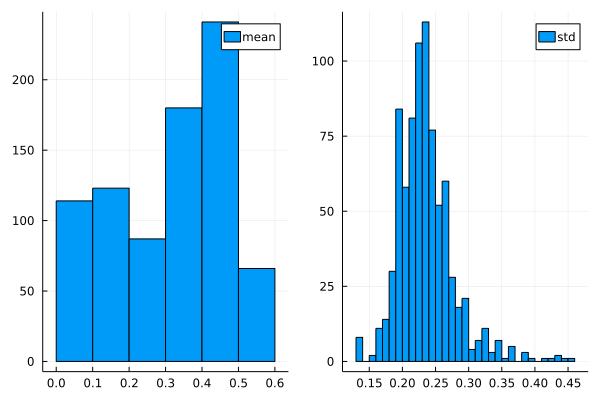

In [16]:
# Check the properties of the proposed normalization
# Actually it seems very dispersed which may be problematic for clustering process
distr_norm = select(sales, AsTable(r"^Normalized") .=> ByRow.([mean, std]) .=> [:mean, :std]);

plot(histogram(distr_norm.mean, label="mean"), histogram(distr_norm.std, label="std"))

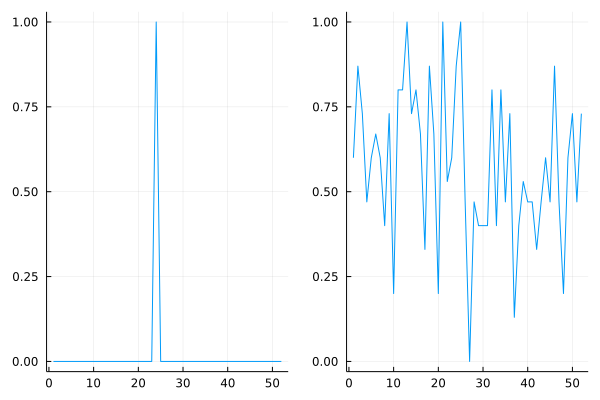

In [17]:
# Investigate the time series with lowest and highest means
plot([plot(Vector(sales[row, r"^Normalized"]), label=nothing)
     for row in [argmin(distr_norm.mean), argmax(distr_norm.mean)]]...)

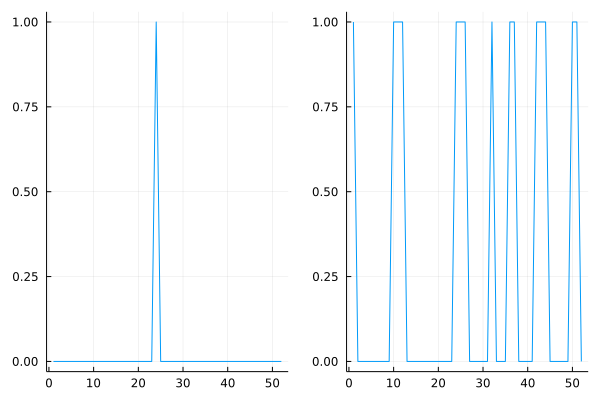

In [18]:
# Investigate the time series with lowest and highest standard deviations
plot([plot(Vector(sales[row, r"^Normalized"]), label=nothing)
     for row in [argmin(distr_norm.std), argmax(distr_norm.std)]]...)

In [19]:
# Transpose the data frame on Product_Code and only keep Wi variables
sales_transposed = permutedims(select(sales, Cols(:Product_Code, r"W")), :Product_Code)

,Product_Code,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52,P53,P54,P55,P56,P57,P58,P59,P60,P61,P62,P63,P64,P65,P66,P67,P68,P69,P70,P71,P72,P73,P74,P75,P76,P77,P78,P79,P80,P81,P82,P83,P84,P85,P86,P87,P88,P89,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101,P102,P103,P104,P105,P106,P107,P108,P109,P110,P111,P112,P113,P114,P115,P116,P117,P118,P119,P120,P121,P122,P123,P124,P125,P126,P127,P128,P129,P130,P131,P132,P133,P134,P135,P136,P137,P138,P139,P140,P141,P142,P143,P144,P145,P146,P147,P148,P149,P150,P151,P152,P153,P154,P155,P156,P157,P158,P159,P160,P161,P162,P163,P164,P165,P166,P167,P168,P169,P170
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,W0,11,7,7,12,8,3,4,8,14,22,15,3,12,14,19,30,49,40,26,13,12,8,3,36,26,14,44,34,13,46,7,15,15,47,34,41,36,37,31,41,35,42,28,34,40,27,40,29,37,12,19,40,2,41,34,31,38,32,5,37,25,12,37,34,14,35,36,14,26,31,7,26,35,8,34,27,7,39,37,38,14,10,46,29,39,37,30,41,24,42,10,26,11,14,12,31,29,4,16,13,26,34,7,4,2,11,19,0,9,9,5,31,22,7,9,13,6,16,30,37,7,7,5,4,6,3,4,36,21,19,29,39,30,32,38,39,37,36,32,28,27,23,31,9,10,7,10,3,11,4,3,11,22,12,5,1,12,8,2,9,5,13,6,9,9,7,33,34,38,29
2,W1,12,6,11,8,5,3,8,6,9,19,7,4,10,12,45,27,40,38,31,17,5,14,5,42,28,14,34,32,10,36,17,13,12,42,37,32,39,36,21,27,27,27,43,27,29,46,42,51,28,3,14,44,5,42,30,28,26,34,13,41,30,27,39,37,10,41,30,11,43,39,11,34,30,9,45,34,7,40,34,29,6,12,40,26,34,33,38,28,26,34,11,36,9,9,15,35,37,2,11,6,51,41,5,4,3,10,19,2,8,12,4,36,26,6,9,7,2,13,40,35,10,10,5,6,9,8,0,43,36,53,32,36,48,41,32,37,41,44,36,36,45,29,35,13,12,13,4,2,9,3,7,10,9,14,7,4,8,3,2,8,6,9,5,5,13,10,45,29,31,37
3,W2,10,3,8,13,13,2,3,10,10,19,15,1,9,9,47,27,40,39,45,11,9,8,4,27,33,9,33,36,12,45,6,10,11,24,26,39,43,43,28,27,26,40,40,28,39,31,27,40,42,15,17,37,6,37,42,41,37,38,10,46,32,18,54,29,9,45,38,9,46,50,10,39,36,6,37,43,6,31,45,32,13,17,34,31,28,33,35,32,44,40,7,56,10,10,15,36,36,4,9,7,45,22,7,5,3,11,15,2,8,12,7,32,31,7,12,8,3,10,46,27,8,7,3,0,5,8,2,28,44,43,32,45,29,50,36,39,43,22,32,41,40,40,29,17,9,9,9,8,9,3,8,8,11,11,4,6,14,3,9,10,5,12,6,8,9,9,42,34,22,32
4,W3,8,2,9,5,11,7,7,9,7,29,14,6,6,11,42,43,28,38,36,10,8,9,3,33,32,8,39,41,17,34,7,4,17,55,27,45,42,52,39,51,43,27,43,36,34,38,28,33,38,8,27,48,8,40,42,36,43,41,11,27,47,22,44,42,10,34,44,9,39,31,8,41,46,15,27,45,2,39,41,40,5,13,38,39,38,32,39,30,31,39,13,40,13,9,13,44,40,4,21,9,47,32,7,5,2,16,24,0,5,6,4,51,37,8,13,8,3,10,33,30,10,8,6,7,10,3,2,39,47,41,35,41,38,35,37,52,41,35,38,46,34,43,42,12,9,13,9,3,6,4,8,8,10,6,3,6,7,2,5,13,7,9,6,9,16,11,41,59,43,43
5,W4,13,7,10,9,6,6,8,6,11,20,17,4,10,13,29,29,40,39,31,7,9,17,3,40,20,9,34,31,17,35,9,13,10,42,49,38,38,61,53,37,44,32,54,50,37,40,33,43,37,12,14,28,3,29,29,45,51,24,10,51,45,19,30,31,11,50,47,5,41,37,10,39,34,4,40,28,7,44,37,29,8,14,36,28,33,36,37,33,37,47,5,31,5,5,17,36,33,7,9,9,40,36,14,3,5,16,16,3,13,15,4,39,32,10,14,7,3,16,28,31,11,11,4,4,6,5,2,41,26,39,49,43

In [20]:
# Normalize (standardize) to make mean per product equal to 0 and standard deviation equal to 1 
# and drop :Product_Code column
sales_norm = mapcols(x -> (x .- mean(x)) ./ std(x), select(sales_transposed, Not(:Product_Code)))

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52,P53,P54,P55,P56,P57,P58,P59,P60,P61,P62,P63,P64,P65,P66,P67,P68,P69,P70,P71,P72,P73,P74,P75,P76,P77,P78,P79,P80,P81,P82,P83,P84,P85,P86,P87,P88,P89,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101,P102,P103,P104,P105,P106
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.369588,1.27724,-0.579404,1.04645,-0.142511,-0.498219,-0.0405672,-0.237123,0.983832,0.483169,0.965096,-0.470112,0.783898,0.493861,-1.96494,-0.848928,1.84777,1.07741,-0.954593,1.39934,1.03811,-0.34603,-0.636501,-0.0120404,-0.750642,0.983263,1.1921,0.263678,0.226148,1.73689,-0.451463,1.78403,0.953724,1.26766,-0.10993,0.670228,0.0362178,0.0641288,-0.342746,0.652605,0.00466017,1.26108,-1.00828,0.212307,1.07535,-0.742753,0.817533,-0.703073,0.370776,1.08344,0.229837,0.948847,-1.06505,0.714517,0.343167,-0.244034,0.598411,-0.212711,-1.40419,0.504808,-1.03487,-0.829129,0.240485,0.321335,1.33058,-0.0510801,0.512905,1.51857,-1.02136,-0.14412,-1.00276,-1.0893,0.273169,-0.303024,-0.176408,-0.659253,1.15005,0.914915,0.632646,0.911137,1.38497,0.467281,1.43092,-0.607456,0.963944,0.691473,-0.250993,1.57763,-1.06982,1.38263,0.429042,-1.14913,0.702848,2.05291,-0.0833461,-0.500986,-0.365434,-0.0204771,2.09249,0.397337,-1.12565,0.364633,-0.411871,0.0194259,-0.897847,0.087946
2,0.640272,0.854207,0.790096,-0.075517,-1.06883,-0.498219,1.64703,-0.962441,-0.369588,-0.0793262,-1.27781,0.050012,0.254512,0.039334,1.28671,-1.26935,0.743354,0.795874,-0.213715,2.77878,-1.29444,1.17455,0.485467,0.739282,-0.438375,0.983263,-0.0886683,-0.11719,-0.508832,0.450306,2.55829,1.17967,0.108378,0.623928,0.353557,-0.415124,0.439787,-0.0400805,-1.58044,-1.12014,-0.964655,-0.652622,0.712634,-0.804531,-0.358452,1.6093,1.06614,2.01421,-0.995548,-1.98959,-0.837264,1.48956,0.213011,0.851116,-0.223331,-0.671778,-0.883368,0.0862342,1.43146,1.0072,-0.309623,2.25049,0.488113,0.742581,0.172586,0.673328,-0.37613,0.690259,1.27022,0.926484,0.601654,-0.106331,-0.355361,-0.00571743,1.32964,0.200848,1.15005,1.04455,0.224825,-0.216937,-0.78917,1.10672,0.661183,-0.99583,0.304403,0.0377167,1.00699,-0.530034,-0.809255,0.171738,0.783171,-0.0506968,0.0885943,0.0833283,0.729278,0.0445904,0.752363,-1.08529,0.533614,-1.0937,1.8187,1.42644,-1.07087,0.0194259,-0.384792,-0.216934
3,0.0989037,-0.414901,-0.237029,1.32694,1.40135,-0.903022,-0.462466,0.488195,-0.0989037,-0.0793262,0.965096,-1.51036,-0.0101805,-0.642456,1.53684,-1.26935,0.743354,0.936641,1.86074,0.709618,0.0384487,-0.34603,-0.075517,-1.13902,0.342293,-0.34134,-0.216745,0.644546,-0.0188456,1.60823,-0.752438,0.273124,-0.173404,-1.69352,-1.34589,0.429039,0.977879,0.689385,-0.714054,-1.12014,-1.08582,1.00592,0.368452,-0.659269,0.945009,-0.247584,-0.798409,0.655568,1.12985,2.10779,-0.197003,0.543312,0.639033,0.168122,1.47616,1.18178,0.474929,0.684124,0.36809,1.63519,-0.0195258,0.40272,2.34532,-0.380741,-0.116913,1.15627,0.80925,0.138052,1.67462,2.39856,0.200551,0.508027,0.398875,-0.897637,0.234333,1.30669,0.69003,-0.122155,1.72017,0.159087,1.1132,2.70531,-0.108552,-0.348541,-0.487045,0.03771

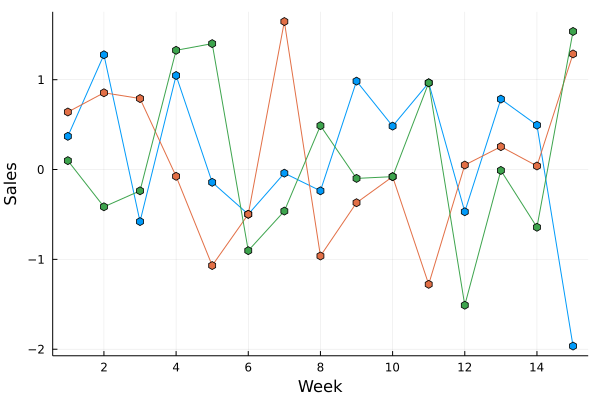

In [21]:
# Plot 15 weeks of sales for first 3 products in the dataset
plot(transpose(Matrix(sales_norm[1:3,1:15])), xlab="Week", ylab="Sales", markershape = :hexagon, legend=false)

In [22]:
# Save sales_norm dataset as Arrow file
Arrow.write("sales_norm.arrow", sales_norm)

"sales_norm.arrow"